**Colab Setup (GPU + Install)**

In [10]:
# CHANGE THIS TO YOUR ACTUAL FOLDER
DATA_ROOT = "/content/drive/MyDrive/object counting using DETR"

train_img_dir  = "/content/drive/MyDrive/object counting using DETR/train/images"
train_ann_file = "/content/drive/MyDrive/object counting using DETR/train/_annotations.coco.json"

valid_img_dir  = "/content/drive/MyDrive/object counting using DETR/valid/images"
valid_ann_file = "/content/drive/MyDrive/object counting using DETR/valid/_annotations.coco.json"

test_img_dir   = "/content/drive/MyDrive/object counting using DETR/test/images"
test_ann_file  = "/content/drive/MyDrive/object counting using DETR/test/_annotations.coco.json"

print("Train images dir :", train_img_dir)
print("Valid images dir :", valid_img_dir)
print("Test images dir  :", test_img_dir)


Train images dir : /content/drive/MyDrive/object counting using DETR/train/images
Valid images dir : /content/drive/MyDrive/object counting using DETR/valid/images
Test images dir  : /content/drive/MyDrive/object counting using DETR/test/images


In [11]:
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q pycocotools opencv-python matplotlib

In [12]:
import os
import time
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.utils.data
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
import torchvision.transforms.functional as F

from pycocotools.coco import COCO

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device:", device)

Using device: cuda


In [13]:
class COCODetectionFasterRCNN(Dataset):
    def __init__(self, images_dir, ann_file, transforms=None):
        """
        images_dir: folder containing images
        ann_file:   COCO json (e.g. _annotations.coco.json)
        """
        self.images_dir = images_dir
        self.coco = COCO(ann_file)
        self.transforms = transforms

        # All image IDs
        self.img_ids = sorted(self.coco.getImgIds())

        # Map COCO category IDs -> contiguous labels 1..K
        cat_ids = sorted(self.coco.getCatIds())
        self.cat_id_to_label = {cat_id: i + 1 for i, cat_id in enumerate(cat_ids)}
        self.label_to_cat_id = {v: k for k, v in self.cat_id_to_label.items()}

        # label index -> class name
        cats = self.coco.loadCats(cat_ids)
        self.label_to_name = {i + 1: c["name"] for i, c in enumerate(cats)}

        print("Classes (COCO category_id -> label_index):")
        for cat in cats:
            cid = cat["id"]
            print(f"  {cat['name']:12s}  cat_id={cid:<3d} -> label={self.cat_id_to_label[cid]}")

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]

        # Image info from COCO
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = img_info["file_name"]
        img_full_path = os.path.join(self.images_dir, img_path)

        # Load image
        img = Image.open(img_full_path).convert("RGB")

        # Load annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []
        areas = []
        iscrowd = []

        for ann in anns:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(self.cat_id_to_label[ann["category_id"]])
            areas.append(ann["area"])
            iscrowd.append(ann.get("iscrowd", 0))

        boxes   = torch.as_tensor(boxes, dtype=torch.float32)
        labels  = torch.as_tensor(labels, dtype=torch.int64)
        areas   = torch.as_tensor(areas, dtype=torch.float32)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_id]),
            "area": areas,
            "iscrowd": iscrowd,
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target


In [14]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class ToTensorDetection:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target


class RandomHorizontalFlipDetection:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            # Flip image
            image = F.hflip(image)
            w = image.shape[-1]

            boxes = target["boxes"]
            x_min = boxes[:, 0]
            y_min = boxes[:, 1]
            x_max = boxes[:, 2]
            y_max = boxes[:, 3]

            # Horizontal flip: x' = w - x
            new_x_min = w - x_max
            new_x_max = w - x_min

            boxes[:, 0] = new_x_min
            boxes[:, 2] = new_x_max
            target["boxes"] = boxes

        return image, target


def get_transform(train=True):
    transforms = [ToTensorDetection()]
    if train:
        transforms.append(RandomHorizontalFlipDetection(0.5))
    return Compose(transforms)


def collate_fn(batch):
    return tuple(zip(*batch))


In [15]:
dataset_train = COCODetectionFasterRCNN(
    images_dir=train_img_dir,
    ann_file=train_ann_file,
    transforms=get_transform(train=True),
)

dataset_valid = COCODetectionFasterRCNN(
    images_dir=valid_img_dir,
    ann_file=valid_ann_file,
    transforms=get_transform(train=False),
)

train_loader = DataLoader(
    dataset_train,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn,
)

valid_loader = DataLoader(
    dataset_valid,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn,
)

num_classes = len(dataset_train.cat_id_to_label) + 1  # +1 for background
print("Number of classes (including background):", num_classes)


loading annotations into memory...
Done (t=0.92s)
creating index...
index created!
Classes (COCO category_id -> label_index):
  Ambulance     cat_id=1   -> label=1
  Bus           cat_id=2   -> label=2
  Car           cat_id=3   -> label=3
  Motorcycle    cat_id=4   -> label=4
  Truck         cat_id=5   -> label=5
loading annotations into memory...
Done (t=0.85s)
creating index...
index created!
Classes (COCO category_id -> label_index):
  Ambulance     cat_id=1   -> label=1
  Bus           cat_id=2   -> label=2
  Car           cat_id=3   -> label=3
  Motorcycle    cat_id=4   -> label=4
  Truck         cat_id=5   -> label=5
Number of classes (including background): 6


In [16]:
img, target = dataset_train[0]
print("Image shape:", img.shape)
print("Boxes shape:", target["boxes"].shape)
print("Labels:", target["labels"])


Image shape: torch.Size([3, 416, 416])
Boxes shape: torch.Size([1, 4])
Labels: tensor([5])


In [17]:
def get_model(num_classes):
    # Load pretrained Faster R-CNN
    model = fasterrcnn_resnet50_fpn(weights="COCO_V1")

    # Replace the box predictor head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

model = get_model(num_classes)
model.to(device)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:01<00:00, 148MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [18]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005,
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1,
)


In [19]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_every=50):
    model.train()
    all_losses = []

    start = time.time()
    for step, (images, targets) in enumerate(data_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        all_losses.append(losses.item())

        if (step + 1) % print_every == 0:
            print(
                f"[Epoch {epoch} | Step {step+1}/{len(data_loader)}] "
                f"Loss: {losses.item():.4f}"
            )

    mean_loss = np.mean(all_losses) if all_losses else 0.0
    elapsed = time.time() - start
    print(f"Epoch {epoch} finished. Mean Loss: {mean_loss:.4f}. Time: {elapsed:.1f}s")
    return mean_loss


In [20]:
num_epochs = 5  # you can increase later (10–20)

for epoch in range(1, num_epochs + 1):
    loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()

MODEL_PATH = "fasterrcnn_vehicles_openimages.pth"
torch.save(model.state_dict(), MODEL_PATH)
print("Model saved as:", MODEL_PATH)


[Epoch 1 | Step 50/220] Loss: 0.5842
[Epoch 1 | Step 100/220] Loss: 0.3276
[Epoch 1 | Step 150/220] Loss: 0.3866
[Epoch 1 | Step 200/220] Loss: 0.1485
Epoch 1 finished. Mean Loss: 0.3500. Time: 330.0s
[Epoch 2 | Step 50/220] Loss: 0.2782
[Epoch 2 | Step 100/220] Loss: 0.2426
[Epoch 2 | Step 150/220] Loss: 0.0981
[Epoch 2 | Step 200/220] Loss: 0.2319
Epoch 2 finished. Mean Loss: 0.2108. Time: 173.8s
[Epoch 3 | Step 50/220] Loss: 0.1102
[Epoch 3 | Step 100/220] Loss: 0.0675
[Epoch 3 | Step 150/220] Loss: 0.1551
[Epoch 3 | Step 200/220] Loss: 0.1391
Epoch 3 finished. Mean Loss: 0.1717. Time: 174.0s
[Epoch 4 | Step 50/220] Loss: 0.1653
[Epoch 4 | Step 100/220] Loss: 0.1506
[Epoch 4 | Step 150/220] Loss: 0.1002
[Epoch 4 | Step 200/220] Loss: 0.1867
Epoch 4 finished. Mean Loss: 0.1199. Time: 173.9s
[Epoch 5 | Step 50/220] Loss: 0.1553
[Epoch 5 | Step 100/220] Loss: 0.0761
[Epoch 5 | Step 150/220] Loss: 0.0870
[Epoch 5 | Step 200/220] Loss: 0.0889
Epoch 5 finished. Mean Loss: 0.1092. Time: 17

In [21]:
# Reload for inference
inference_model = get_model(num_classes)
inference_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
inference_model.to(device)
inference_model.eval()

# For single-image inference we only need ToTensor (no target)
inference_transform = T.ToTensor()


In [22]:
# Map dataset class names to friendly names
FRIENDLY_NAME_MAP = {
    "Motorcycle": "Bike",
    "motorcycle": "Bike",
    "Car": "Car",
    "car": "Car",
    "Bus": "Bus",
    "bus": "Bus",
    "Truck": "Truck",
    "truck": "Truck",
    "Ambulance": "Ambulance",
    "ambulance": "Ambulance",
}


In [23]:
def detect_and_count_single_image(img_path, model, dataset, score_thresh=0.5):
    """
    Detects vehicles in a single image, draws boxes + labels,
    and prints:
      - Total vehicles
      - Count of each vehicle type (Car, Bike, Bus, Truck, Ambulance, etc.)
    """
    # 1) Load image
    img = Image.open(img_path).convert("RGB")
    img_tensor = inference_transform(img).to(device)

    # 2) Model inference
    with torch.no_grad():
        outputs = model([img_tensor])[0]

    boxes  = outputs["boxes"].cpu().numpy()
    scores = outputs["scores"].cpu().numpy()
    labels = outputs["labels"].cpu().numpy()

    # 3) Filter by score
    keep = scores >= score_thresh
    boxes  = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]

    # 4) Count per class
    label_names = dataset.label_to_name
    per_class_counts = {}

    for lb in labels:
        raw_name = label_names.get(int(lb), f"class_{int(lb)}")
        friendly = FRIENDLY_NAME_MAP.get(raw_name, raw_name)
        per_class_counts[friendly] = per_class_counts.get(friendly, 0) + 1

    total_vehicles = sum(per_class_counts.values())

    print("=== Vehicle Count Summary ===")
    print(f"Total vehicles detected (score >= {score_thresh}): {total_vehicles}")
    for cls_name, count in per_class_counts.items():
        print(f"  {cls_name}: {count}")

    # 5) Draw boxes
    img_cv = np.array(img)[:, :, ::-1].copy()  # RGB -> BGR for OpenCV

    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box.astype(int)
        raw_name = label_names.get(int(label), f"class_{int(label)}")
        friendly = FRIENDLY_NAME_MAP.get(raw_name, raw_name)

        cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
        text = f"{friendly} {score:.2f}"
        cv2.putText(
            img_cv,
            text,
            (x1, max(y1 - 5, 0)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 255, 0),
            1,
            cv2.LINE_AA,
        )

    # 6) Show image
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    return total_vehicles, per_class_counts


Example test images: ['59b1c028bd8b08dc_jpg.rf.7cee04415facc914c97d31374c550472.jpg', '479012386aa308fb_jpg.rf.24d80cdb95dae89bc61b36651306c45f.jpg', '08c8b73e0c2e296e_jpg.rf.7IkYAamjZhnwsoXSrwKt.jpg', '47b09b34e24b4039_jpg.rf.SXhYsnLDkwnvDNU811ds.jpg', '31d30eccf56cac5f_jpg.rf.DPfttPJtcKnLajb1gulu.jpg']
=== Vehicle Count Summary ===
Total vehicles detected (score >= 0.5): 3
  Bus: 3


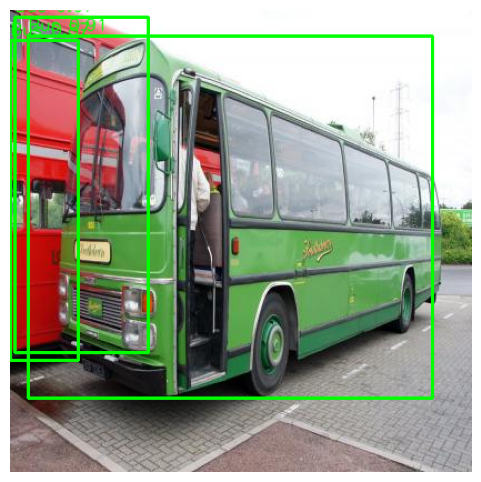

In [24]:
test_images = [f for f in os.listdir(test_img_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
print("Example test images:", test_images[:5])

sample_img_path = os.path.join(test_img_dir, test_images[0])

total, per_cls = detect_and_count_single_image(
    sample_img_path,
    inference_model,
    dataset_train,   # for label_to_name
    score_thresh=0.5,
)


In [25]:
def count_over_dataset(img_dir, model, dataset_for_labels, score_thresh=0.5, max_images=None):
    """
    Runs detection on all images in img_dir and prints:
      - Total vehicles
      - Average vehicles per image
      - Per-class totals
    """
    img_files = [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    img_files = sorted(img_files)

    if max_images is not None:
        img_files = img_files[:max_images]

    total_images = len(img_files)
    total_count = 0
    per_class_global = {}

    label_names = dataset_for_labels.label_to_name

    model.eval()

    for i, fname in enumerate(img_files, 1):
        img_path = os.path.join(img_dir, fname)
        img = Image.open(img_path).convert("RGB")
        img_tensor = inference_transform(img).to(device)

        with torch.no_grad():
            outputs = model([img_tensor])[0]

        scores = outputs["scores"].cpu().numpy()
        labels = outputs["labels"].cpu().numpy()

        keep = scores >= score_thresh
        labels = labels[keep]

        for lb in labels:
            raw_name = label_names.get(int(lb), f"class_{int(lb)}")
            friendly = FRIENDLY_NAME_MAP.get(raw_name, raw_name)

            total_count += 1
            per_class_global[friendly] = per_class_global.get(friendly, 0) + 1

        if i % 50 == 0:
            print(f"Processed {i}/{total_images} images...")

    print("\n=== Dataset Vehicle Count Summary ===")
    print(f"Images processed:        {total_images}")
    print(f"Total vehicles detected: {total_count}")
    avg = total_count / max(total_images, 1)
    print(f"Average vehicles/image:  {avg:.2f}")
    print("Per-class totals:")
    for cls_name, count in per_class_global.items():
        print(f"  {cls_name}: {count}")

    return total_count, per_class_global


In [26]:
total_test, per_class_test = count_over_dataset(
    test_img_dir,
    inference_model,
    dataset_train,
    score_thresh=0.5,
    max_images=None,  # or e.g. 50 for quicker test
)


Processed 50/126 images...
Processed 100/126 images...

=== Dataset Vehicle Count Summary ===
Images processed:        126
Total vehicles detected: 284
Average vehicles/image:  2.25
Per-class totals:
  Ambulance: 22
  Bus: 38
  Car: 160
  Bike: 34
  Truck: 30


In [27]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

def test_image_from_url(image_url, model, dataset, score_thresh=0.5):
    print("Downloading image...")
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).convert("RGB")

    # Convert for model
    img_tensor = inference_transform(img).to(device)

    # Run inference
    with torch.no_grad():
        outputs = model([img_tensor])[0]

    boxes  = outputs["boxes"].cpu().numpy()
    scores = outputs["scores"].cpu().numpy()
    labels = outputs["labels"].cpu().numpy()

    # Keep predictions above threshold
    keep = scores >= score_thresh
    boxes  = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]

    # Count per class
    label_names = dataset.label_to_name
    per_class_counts = {}
    for lb in labels:
        raw_name = label_names.get(int(lb), f"class_{int(lb)}")
        friendly = FRIENDLY_NAME_MAP.get(raw_name, raw_name)
        per_class_counts[friendly] = per_class_counts.get(friendly, 0) + 1

    total_vehicles = sum(per_class_counts.values())

    print("\n===== RESULT FOR URL IMAGE =====")
    print("Image URL:", image_url)
    print("Total Vehicles:", total_vehicles)
    for cls_name, count in per_class_counts.items():
        print(f"  {cls_name}: {count}")

    # Draw detections
    img_cv = np.array(img)[:, :, ::-1].copy()
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box.astype(int)
        raw_name = label_names.get(int(label), f"class_{int(label)}")
        friendly = FRIENDLY_NAME_MAP.get(raw_name, raw_name)
        cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_cv,
                    f"{friendly} {score:.2f}",
                    (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6,
                    (0,255,0),
                    2)

    # Display image
    plt.figure(figsize=(7,7))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    return total_vehicles, per_class_counts


In [29]:
test_image_from_url(
    "http://lawnet.vn/thong-tin-phap-luat/en/tu-van-luat/guidelines-for-registration-and-organization-of-legal-knowledge-examination-on-road-traffic-order-and-safety-in-vietnam-174108.html",
    inference_model,
    dataset_train,
    score_thresh=0.5
)


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x78e39829af20>

In [48]:
import requests
from io import BytesIO
from PIL import Image, UnidentifiedImageError
import numpy as np
import cv2
import matplotlib.pyplot as plt

def test_image_from_url(image_url, model, dataset, score_thresh=0.5):
    print("Checking URL...")
    r = requests.get(image_url, stream=True, timeout=10)

    # Check if the URL is an actual image (important fix)
    content_type = r.headers.get("Content-Type", "")
    if not any(x in content_type for x in ["image/jpeg", "image/png", "image/jpg"]):
        print("\n❌ ERROR: This URL is NOT a direct image link.")
        print("Please provide a link ending in .jpg / .jpeg / .png\n")
        print("Example of a valid image URL:")
        print("https://images.pexels.com/photos/358070/pexels-photo-358070.jpeg")
        return None, None

    try:
        img = Image.open(BytesIO(r.content)).convert("RGB")
    except UnidentifiedImageError:
        print("\n❌ Could not identify image. The link is not a valid image file.")
        return None, None

    # Convert image for model
    img_tensor = inference_transform(img).to(device)

    # Run inference
    with torch.no_grad():
        outputs = model([img_tensor])[0]

    boxes  = outputs["boxes"].cpu().numpy()
    scores = outputs["scores"].cpu().numpy()
    labels = outputs["labels"].cpu().numpy()

    keep = scores >= score_thresh
    boxes  = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]

    # Count
    label_names = dataset.label_to_name
    per_class_counts = {}
    for lb in labels:
        raw_name = label_names.get(int(lb), f"class_{int(lb)}")
        friendly = FRIENDLY_NAME_MAP.get(raw_name, raw_name)
        per_class_counts[friendly] = per_class_counts.get(friendly, 0) + 1

    total_vehicles = sum(per_class_counts.values())

    print("\n===== RESULT ===telek")
    print("URL:", image_url)
    print("Total Vehicles:", total_vehicles)
    for cls_name, count in per_class_counts.items():
        print(f"  {cls_name}: {count}")

    # Draw results
    img_cv = np.array(img)[:, :, ::-1].copy()
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box.astype(int)
        raw_name = label_names.get(int(label), f"class_{int(label)}")
        friendly = FRIENDLY_NAME_MAP.get(raw_name, raw_name)
        # Dark bold bounding box and label
        box_color = (0, 0, 150)  # Black / Very Dark
        thickness = 8          # Increase line thickness

        cv2.rectangle(img_cv, (x1, y1), (x2, y2), box_color, thickness)
        cv2.putText(
            img_cv,
            f"{friendly} {score:.2f}",
            (x1, y1 - 8),
            cv2.FONT_HERSHEY_SIMPLEX,
            4,
            box_color,
            8,  # thicker text for visibility
            cv2.LINE_AA,
        )

        #cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
        #cv2.putText(img_cv, f"{friendly} {score:.2f}", (x1, y1 - 5),
                    #cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

    plt.figure(figsize=(7,7))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    return total_vehicles, per_class_counts

Checking URL...

===== RESULT ===telek
URL: https://images.pexels.com/photos/358070/pexels-photo-358070.jpeg
Total Vehicles: 1
  Car: 1


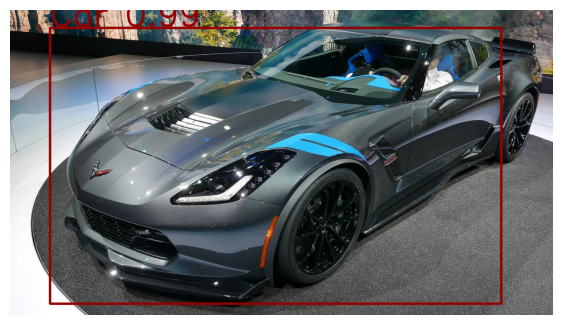

(1, {'Car': 1})

In [49]:
test_image_from_url(
    "https://images.pexels.com/photos/358070/pexels-photo-358070.jpeg",
    inference_model,
    dataset_train,
    score_thresh=0.5
)


In [50]:
test_image_from_url(
    "https://upload.wikimedia.org/wikipedia/commons/2/25/Blue_car.jpg",
    inference_model,
    dataset_train,
    score_thresh=0.5
)


Checking URL...

❌ ERROR: This URL is NOT a direct image link.
Please provide a link ending in .jpg / .jpeg / .png

Example of a valid image URL:
https://images.pexels.com/photos/358070/pexels-photo-358070.jpeg


(None, None)

Checking URL...

===== RESULT ===telek
URL: https://images.pexels.com/photos/33895618/pexels-photo-33895618.jpeg
Total Vehicles: 2
  Car: 1
  Bus: 1


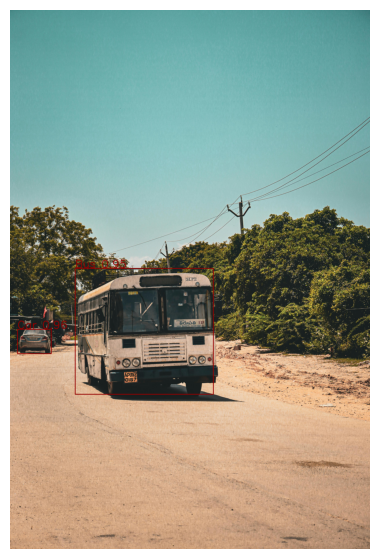

(2, {'Car': 1, 'Bus': 1})

In [51]:
test_image_from_url(
    "https://images.pexels.com/photos/33895618/pexels-photo-33895618.jpeg",
    inference_model,
    dataset_train,
    score_thresh=0.5
)
